# Fitting a resonator measured in reflection

In [1]:
%cd D:\Github\rf-analysis-tools\resonator_tools
from resonator_tools import circuit
import numpy as np
import pandas as pd
from IPython.display import display
import numpy as np
import xarray as xr
import holoviews as hv

from qcodes import initialise_or_create_database_at, load_by_run_spec


import pandas as pd


C:\Users\Amine Selmani\AppData\Roaming\Python\Python310\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


D:\Github\rf-analysis-tools\resonator_tools


Although we could use the resonator tools to load data, here we want to use the Pandas library, which is used for statistical data analysis. It can handle many different file types including hdf5.

In [2]:
initialise_or_create_database_at(
    r"D:\Github\Qinu\qumin\data\2025-07-07_C12-036-L&C12-036-I.db"
)
# peak1 = load_by_run_spec(captured_run_id=2).to_xarray_dataset()

In [3]:
peak1 = load_by_run_spec(captured_run_id=75).to_xarray_dataset().sel({'pna_power':-30})

Pandas has a very nice way of displaying the data. Let's look at the first few entries:

In [4]:
display(peak1.head())

<xarray.Dataset> Size: 208B
Dimensions:                   (pna_frequency_axis: 5)
Coordinates:
    pna_power                 float64 8B -30.0
  * pna_frequency_axis        (pna_frequency_axis) float64 40B 5.454e+09 ... ...
Data variables:
    pna_tr1_linear_magnitude  (pna_frequency_axis) float64 40B 1.479 ... 1.479
    pna_tr1_magnitude         (pna_frequency_axis) float64 40B 3.402 ... 3.402
    pna_tr1_phase             (pna_frequency_axis) float64 40B -165.7 ... -165.7
    pna_tr1_unwrapped_phase   (pna_frequency_axis) float64 40B -165.7 ... -165.7
Attributes: (12/19)
    ds_name:                        results
    sample_name:                    C12-036-I
    exp_name:                       S21 cavity HI
    snapshot:                       {"station": {"instruments": {"pna": {"fun...
    guid:                           da2731bd-0000-0000-0000-0197eae88dc6
    run_timestamp:                  2025-07-08 18:39:59
    ...                             ...
    completed_timestamp_raw:        1751993392.3994594
    indep_params:                   pna_power, pna_frequency_axis
    dep_params:                     pna_tr1_phase, pna_tr1_unwrapped_phase, p...
    git_hash:                       cc54e479c19ea588e7e91d344bd67fb923384d7a
    main_pna_fixed_multifrequency:  from instruments.rf.pamela import pna\nfr...
    setup_pna_2D_multifrequencies:  from instruments.rf.pamela import pna\nfr...

Next, we define a reflection port measurement and add the data.

In [55]:
# port2 = circuit.reflection_port(
#     f_data=peak1["readoutpulsefrequency"].values,
#     z_data_raw=10**(
#     np.log10(((peak1["R"].values / np.sqrt(2)) ** 2 * 1000) / 50))
#     * np.exp(1j * np.pi * peak1["Phi"] / 180),
# )
# port2 = circuit.reflection_port(
#     f_data=peak1["readoutpulsefrequency"].values,
#     z_data_raw=peak1["R"]/2
#         * np.exp(1j * np.pi * peak1["Phi"] / 180),
# )

# # port2 = circuit.reflection_port(
# #     f_data=peak1["readoutpulsefrequency"].values,
# #     z_data_raw=peak1["I"].values - 1j * peak1["Q"].values,
# # )
# # hv.Curve((peak1["I"].values, peak1["Q"].values), kdims=["I"], vdims=["Q"])
# hv.Curve(
#     (peak1["readoutpulsefrequency"].values, 10 * np.log10((((peak1["R"].values / np.sqrt(2)) ** 2) * 1000) / 50)),
#     kdims=["readoutpulsefrequency"], vdims=["Power (dBm)"]
# )

In [5]:
port2 = circuit.reflection_port(
    f_data=peak1["pna_frequency_axis"],
    z_data_raw=peak1["pna_tr1_linear_magnitude"]
    * np.exp(1j * np.pi * peak1["pna_tr1_unwrapped_phase"] / 180),
)

In [57]:
# hv.Curve((peak1["I"].values, peak1["Q"].values), kdims=["I"], vdims=["Q"])

Perform an automated fit.

In [7]:
port2.autofit()

C:\Users\Amine Selmani\miniconda3\envs\qumin_env\lib\site-packages\resonator_tools-0.1-py3.10.egg\resonator_tools\circlefit.py:148: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.


Let's plot the data and the fit!

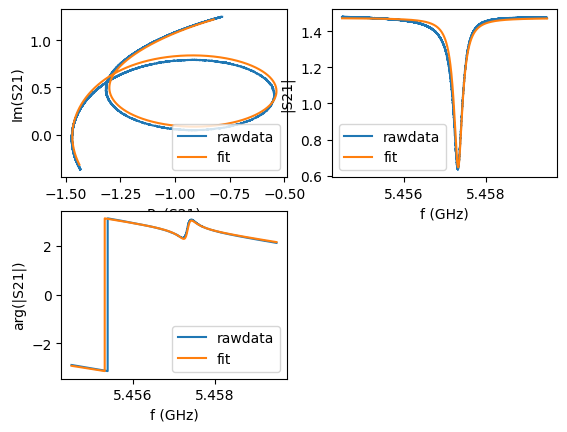

In [8]:
port2.plotall()

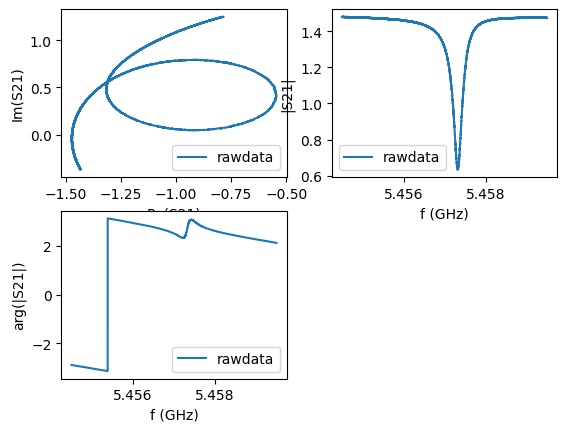

In [9]:
port2.plotrawdata()

In [61]:
# port2.circlefit(
#     f_data=peak1["readoutpulsefrequency"].values,
#     z_data=peak1["I"].values - 1j * peak1["Q"].values,
# )

AttributeError: Axes.set() got an unexpected keyword argument 'axisbg'

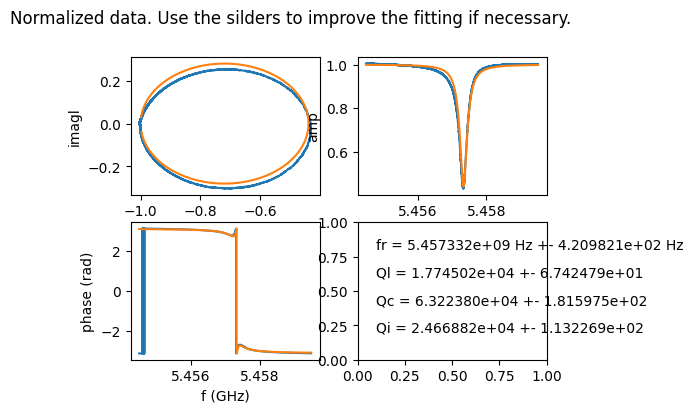

In [12]:

port2.GUIfit()

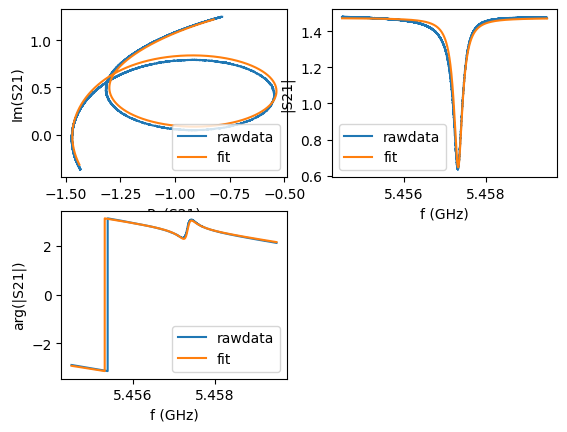

In [11]:
port2.plotall()

In [63]:
display(pd.DataFrame([port2.fitresults]).map(lambda x: "{0:.2e}".format(x)))

,Qi,Qc,Ql,fr,theta0,Ql_err,Qc_err,fr_err,chi_square,Qi_err
0,1.83e+04,2.19e+04,9.98e+03,6.98e+09,-4.94e-01,1.49e+02,2.34e+02,3.63e+03,4.92e-02,4.02e+02


In [64]:
print("Single photon limit: %.2f dBm" % port2.get_single_photon_limit())

Single photon limit: -139.52 dBm


In [65]:
print(
    "At -100dBm, we have %.2e photons in the resonator"
    % port2.get_photons_in_resonator(-100)
)

At -100dBm, we have 8.96e+03 photons in the resonator


In [126]:
# port3 = circuit.notch_port(
#     f_data=peak1["readoutpulsefrequency"].values,
#     z_data_raw=peak1["I"].values - 1j * peak1["Q"].values,
# )
# print()
# port3 = circuit.notch_port(
#     f_data=peak1["readoutpulsefrequency"].values,
#     z_data_raw=peak1["R"].values 
#     * np.exp(1j * np.pi * peak1["Phi"] / 180),
# )
peak1 = load_by_run_spec(captured_run_id=85).to_xarray_dataset().sel({'pna_power':-30})

In [127]:
port3 = circuit.notch_port(
    f_data=peak1["pna_frequency_axis"],
    z_data_raw=peak1["pna_tr1_linear_magnitude"]
    * np.exp(1j * np.pi * peak1["pna_tr1_unwrapped_phase"] / 180),
)

In [128]:
port3.autofit()

C:\Users\Amine Selmani\miniconda3\envs\qumin_env\lib\site-packages\resonator_tools-0.1-py3.10.egg\resonator_tools\circlefit.py:148: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.


In [129]:
# port3.circlefit(
# f_data=peak1["readoutpulsefrequency"].values ,
# z_data=peak1["I"].values - 1j * peak1["Q"].values,
# fr=None,Ql=None,refine_results=True,calc_errors=True)


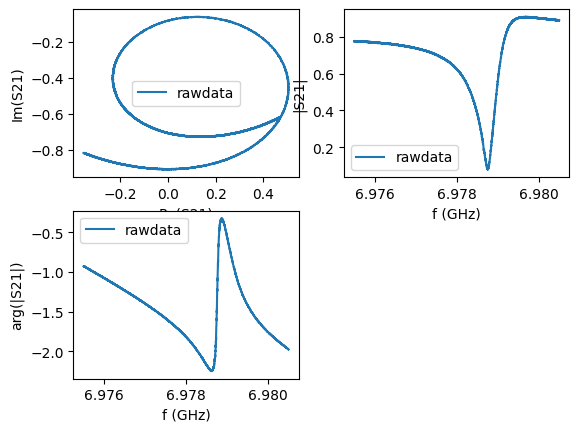

In [130]:
# port3.do_calibration(
#     f_data=peak1["readoutpulsefrequency"].values,
#     z_data=peak1["I"].values - 1j * peak1["Q"].values,
# )
port3.plotrawdata()

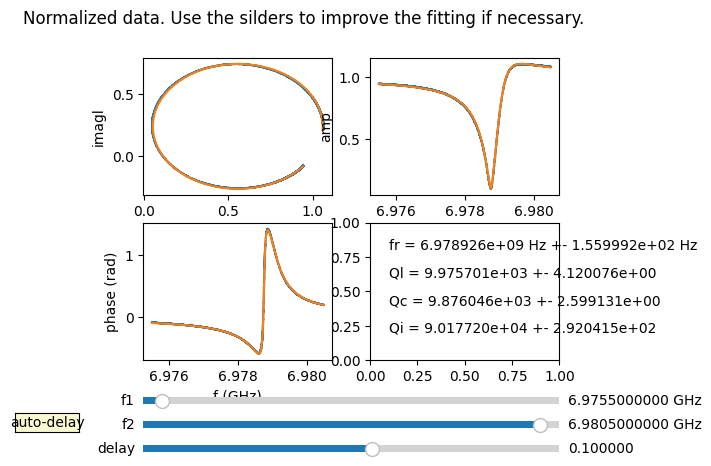

In [131]:
port3.GUIfit()

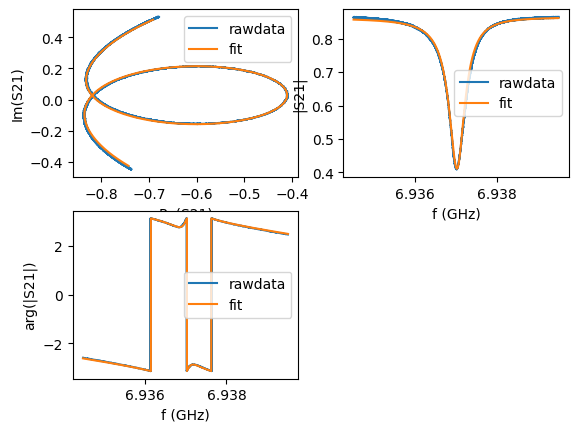

In [119]:
port3.plotall()

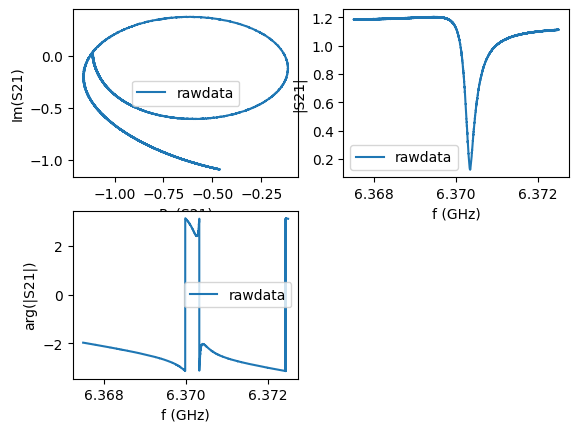

In [88]:
port3.plotrawdata()

Next, let us have a look at the fit results. Here, we convert the dictionary of results into a dataframe to display it in a nicer way.

In [73]:
display(pd.DataFrame([port3.fitresults]).map(lambda x: "{0:.2e}".format(x)))

,Qi_dia_corr,Qi_no_corr,absQc,Qc_dia_corr,Ql,fr,theta0,phi0,phi0_err,Ql_err,absQc_err,fr_err,chi_square,Qi_no_corr_err,Qi_dia_corr_err
0,9.02e+04,-9.89e+05,9.88e+03,1.12e+04,9.98e+03,6.98e+09,2.65e+00,-4.94e-01,3.76e-04,4.12e+00,2.60e+00,1.56e+02,2.97e-05,3.16e+04,2.92e+02


In [51]:
print("Single photon limit: %.2f dBm" % port3.get_single_photon_limit())

Single photon limit: -146.41 dBm


In [52]:
print(
    "At -100dBm, we have %.2e photons in the resonator"
    % port3.get_photons_in_resonator(-100)
)

At -100dBm, we have 4.37e+04 photons in the resonator
